# Pairs Trading Algorithm for Financial Markets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn as sns
!pip install yfinance
!pip install pandas-datareader
from pandas_datareader import data as pdr
import yfinance as yf

Objective A : Collect Historical Prices Data for chosen stocks

I have decided to choose MAANG Stocks + Stocks from other firms in the same industry

In [ ]:
import datetime
tickers =['ADBE', 'AMZN', 'AAPL' , 'META', 'MSFT', 'NFLX', 'TSLA', 'GOOG' , 'ORCL']
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2023, 1, 1)
df = yf.download(tickers, start=start, end=end)['Adj Close'] #Adjusted Price of market after closing taken into account we could also swap this out for closing price.
df_close = yf.download(tickers, start=start, end=end)['Close']
df.tail()

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  9 of 9 completed


Ticker,AAPL,ADBE,AMZN,GOOG,META,MSFT,NFLX,ORCL,TSLA
Date,,,,,,,,,
2022-12-23,130.959961,338.450012,85.250000,89.707916,117.797935,236.195023,294.959991,79.077530,123.150002
2022-12-27,129.142441,335.089996,83.040001,87.830055,116.640312,234.443817,284.170013,79.204689,109.099998
2022-12-28,125.179680,328.329987,81.820000,86.361725,115.382896,232.039627,276.880005,78.568932,112.709999
2022-12-29,128.725311,337.579987,84.180000,88.848892,120.013382,238.450806,291.119995,79.615479,121.820000
2022-12-30,129.043106,336.529999,84.000000,88.629150,120.093216,237.273453,294.880005,79.948029,123.180000


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2518 non-null   float64
 1   ADBE    2518 non-null   float64
 2   AMZN    2518 non-null   float64
 3   GOOG    2518 non-null   float64
 4   META    2518 non-null   float64
 5   MSFT    2518 non-null   float64
 6   NFLX    2518 non-null   float64
 7   ORCL    2518 non-null   float64
 8   TSLA    2518 non-null   float64
dtypes: float64(9)
memory usage: 196.7 KB


In [ ]:
n = df.shape[1]
keys = df.columns
pvalue_matrix = pd.DataFrame(np.ones((n, n)), columns=df.columns, index=df.columns)
pairs = []
for i in range(n):
  for j in range(i+1,n):
    stock1 = df[keys[i]]
    stock2 = df[keys[j]]
    result = coint(stock1, stock2)
    pvalue = result[1]
    pvalue_matrix.iloc[i, j] = pvalue
    if pvalue < 0.05:  # Use a threshold of 0.05
      pairs.append((keys[i], keys[j], pvalue))
for pair in pairs:
    print(pair)

('ADBE', 'AMZN', 0.00036466418697154887)
('GOOG', 'ORCL', 0.031674442301694763)


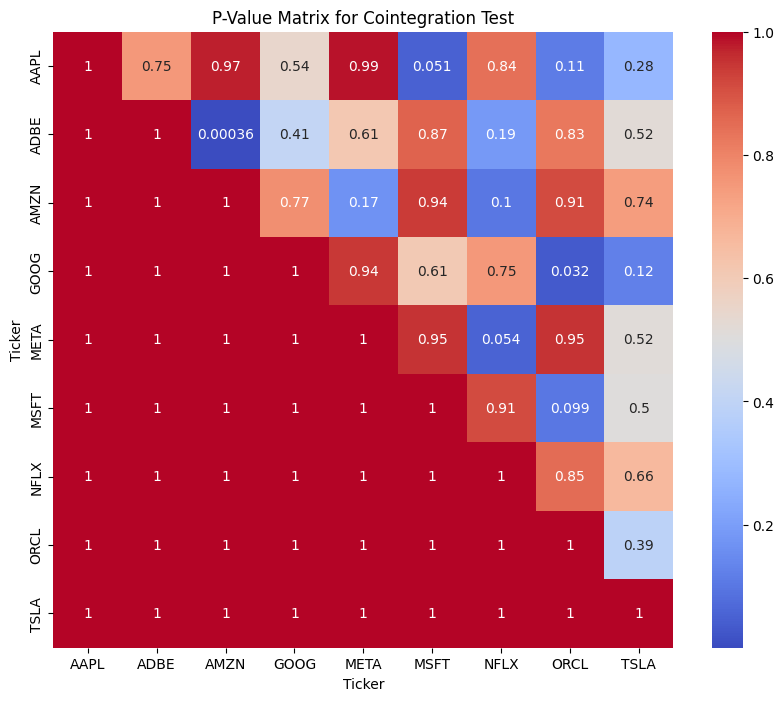

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, annot=True, cmap='coolwarm')
plt.title('P-Value Matrix for Cointegration Test')
plt.show()

This Suggests that Adobe and Amazon are likely to be conintegrated.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


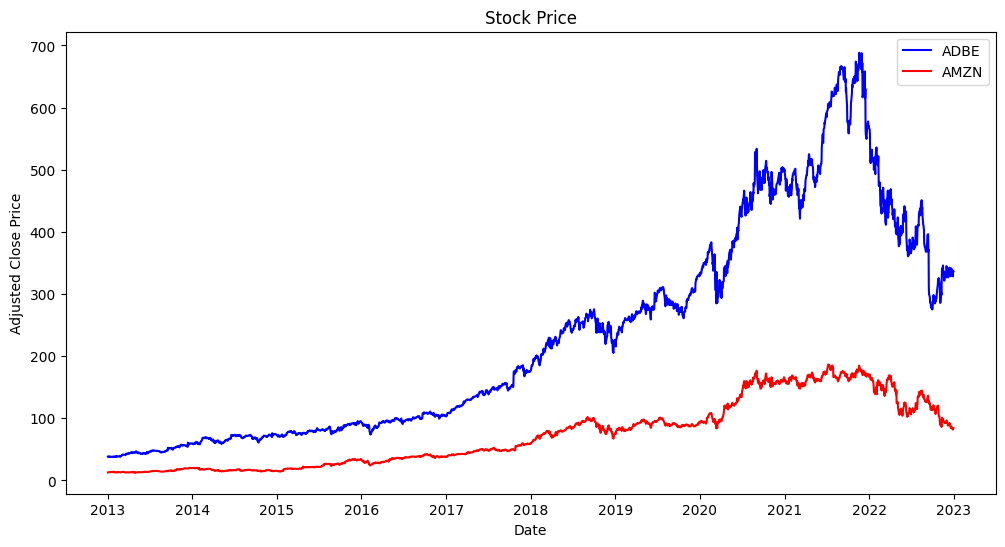

In [ ]:
ticker1 = "ADBE"
ticker2 = "AMZN"

ts1 = yf.download(ticker1, start=start, end=end)['Adj Close']
ts2 = yf.download(ticker2, start=start, end=end)['Adj Close']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts1.index, ts1, label=ticker1, color='blue')
plt.plot(ts2.index, ts2, label=ticker2, color='red')
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

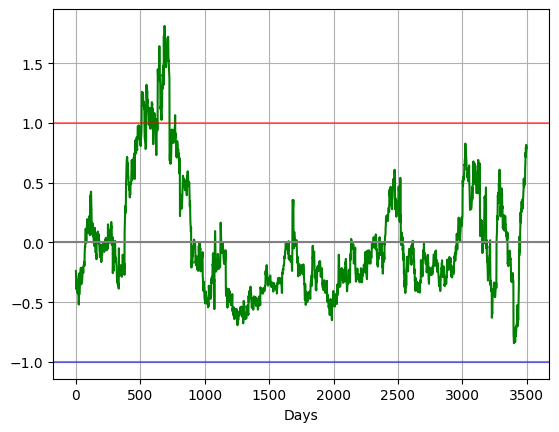

In [ ]:
RV = ts1/ts2
# RV = RV[-1500:-500]
mean = np.mean(RV)
xplot = np.linspace(0, 3500, len(RV))


plt.plot(xplot, RV-mean, color='green')
plt.axhline(0, color='grey')
plt.axhline(1, color='red', alpha=0.5)
plt.axhline(-1,color='blue', alpha=0.5)
plt.xlabel('Days')
plt.grid()

Absolute Ratio may not be the best way of analysis hence we calculate the z-score which tells how many SDs are we away from the mean:

$z = \frac{x_i - ̅x}{σ}$

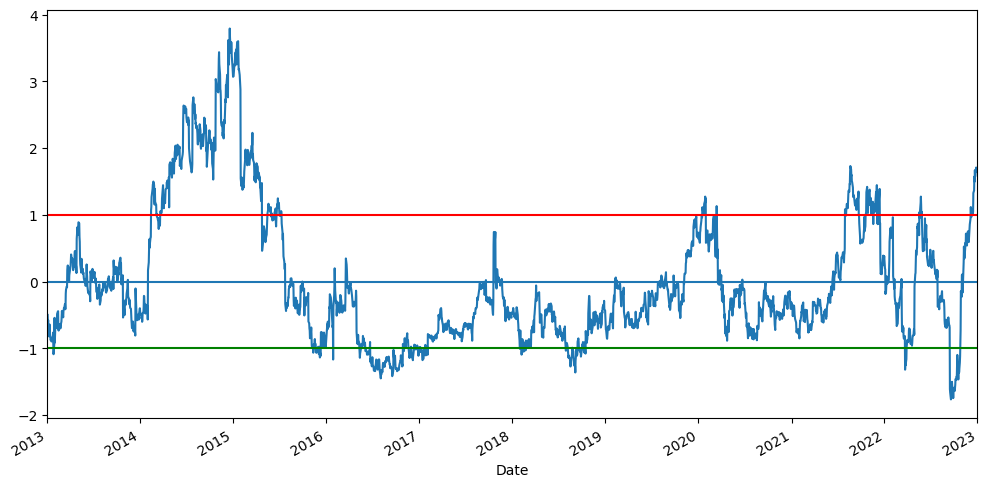

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(RV).plot(figsize=(12,6))
plt.axhline(zscore(RV).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2023-01-01')
plt.show()

#Signals for Buy and Sell

In [ ]:
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) * .70 )

1762.6


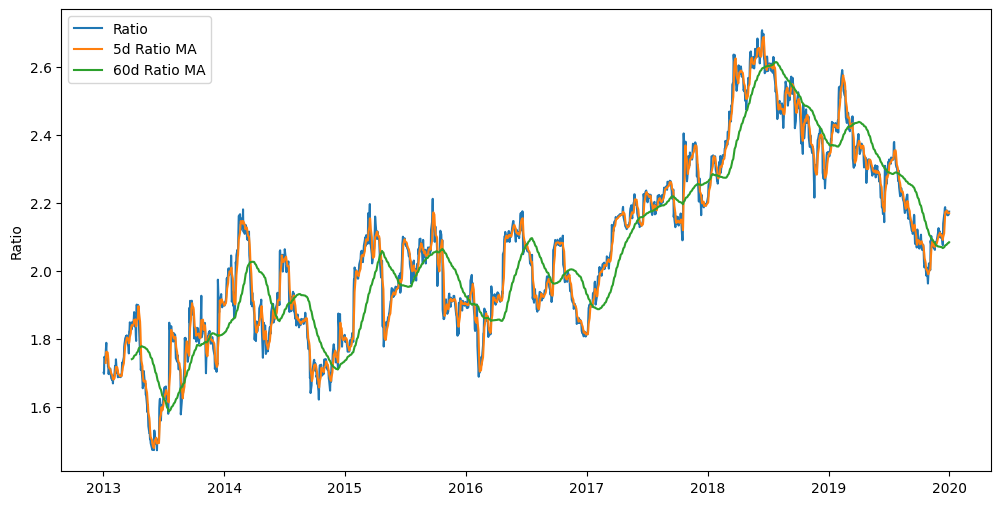

In [ ]:
train = ratios[:1762]
test = ratios[1762:]
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

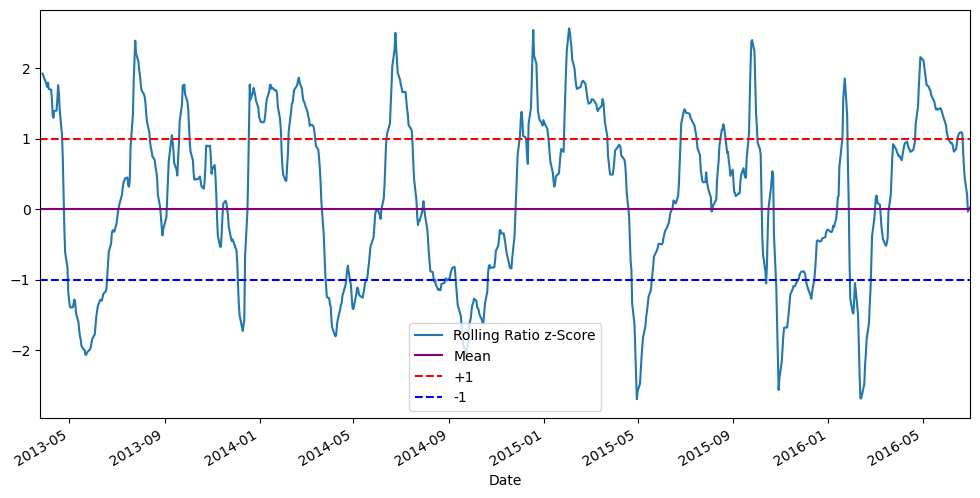

In [ ]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='purple')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='blue', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

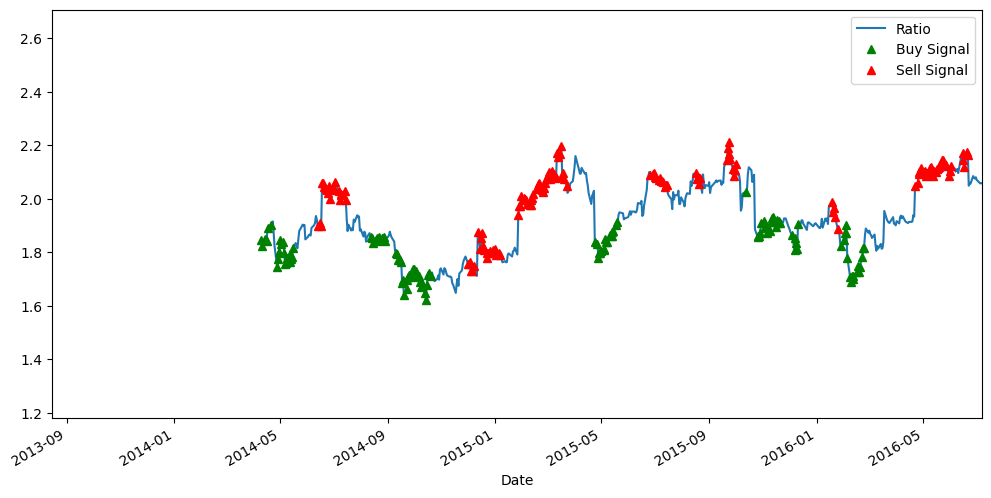

In [ ]:
plt.figure(figsize=(12,6))

train[320:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[320:].plot(color='g', linestyle='None', marker='^')
sell[320:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

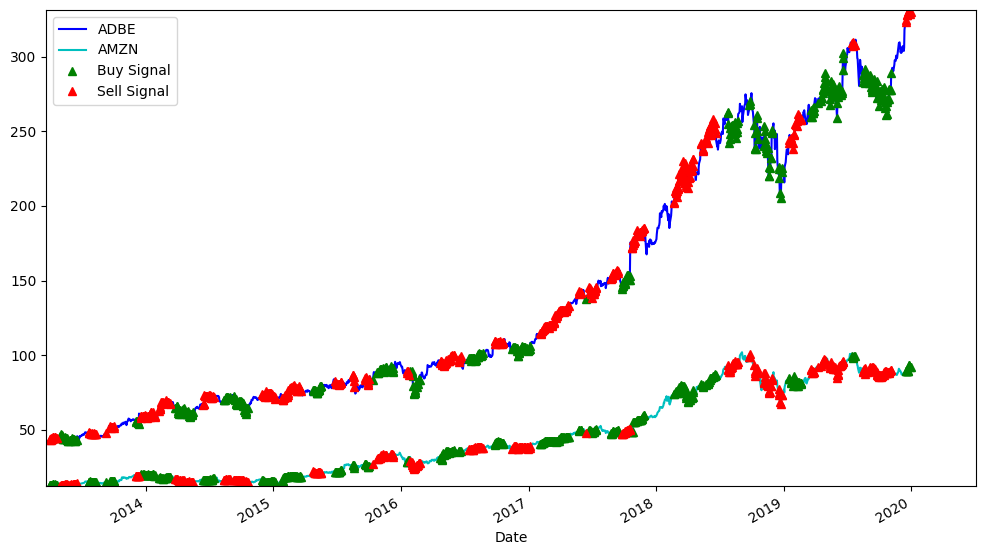

In [ ]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:1762]
S2 = df['AMZN'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
# plt.ylim(25, 105)
plt.xlim('2013-03-22', '2020-07-05')

plt.legend(['ADBE', 'AMZN', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
from scipy.stats import zscore

def trade(S1, S2, window1, window2):
    if (window1 == 0) or (window2 == 0):
        return 0

    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    money = 0
    countS1 = 0
    countS2 = 0

    for i in range(len(ratios)):
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0

    return money


In [ ]:
trade(df['ADBE'].iloc[1788:], df['AMZN'].iloc[1788:], 60, 5)


8668.114658592594

In [ ]:
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2024, 1, 1)
tickers = ['ADBE', 'AMZN']
df2 = yf.download(tickers, start=start, end=end)['Adj Close']

df2.dropna(inplace=True)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
trade(df2['ADBE'], df2['AMZN'], 60, 5)
#on new data profit = ?

2665.80846578202

Now we indetify stocks for a smaller duration of time :

In [ ]:
tickers = ['ADBE', 'AMZN', 'AAPL', 'META', 'MSFT', 'NFLX', 'TSLA', 'GOOG', 'ORCL','KO','BRK-A','AMD','CSCO','QCOM','NVDA']


interval = '15m'  # 15-minute intervals
period = '1mo'   # Past month

# Function to download intraday data for the past month
def download_intraday_data(tickers, period, interval):
    data = yf.download(tickers, period=period, interval=interval)
    return data['Adj Close']

# Download data for all tickers
df = download_intraday_data(tickers, period, interval)

# Display the last few rows of the data
print(df.tail())

# Check for missing data
print(df.isna().sum())

# Handle missing data: drop rows with NaN values
df = df.dropna()

# Check the shape of the data after dropping NaNs
print("Shape after dropping NaNs:", df.shape)

# Prepare for cointegration test
n = df.shape[1]
keys = df.columns
pvalue_matrix = pd.DataFrame(np.ones((n, n)), columns=df.columns, index=df.columns)
pairs = []

# Perform cointegration tests
for i in range(n):
    for j in range(i + 1, n):
        stock1 = df[keys[i]]
        stock2 = df[keys[j]]
        if stock1.size == 0 or stock2.size == 0:
            continue  # Skip if there's no data
        result = coint(stock1, stock2)
        pvalue = result[1]
        pvalue_matrix.iloc[i, j] = pvalue
        if pvalue < 0.05:  # Use a threshold of 0.05
            pairs.append((keys[i], keys[j], pvalue))

# Print the cointegrated pairs
for pair in pairs:
    print(pair)


[*********************100%%**********************]  15 of 15 completed


Ticker                     AAPL        ADBE         AMD        AMZN     BRK-A  \
Datetime                                                                        
2024-06-17 14:45:00  218.706604  518.900024  158.949997  184.389893  612257.5   
2024-06-17 15:00:00  218.210007  520.460022  158.600006  184.699997  613210.0   
2024-06-17 15:15:00  218.154999  521.049988  158.559998  184.809402  613345.5   
2024-06-17 15:30:00  217.330002  519.869995  158.179993  184.750305  613370.0   
2024-06-17 15:45:00  216.710007  518.750000  158.389999  184.080002  613152.5   

Ticker                    CSCO        GOOG         KO        META        MSFT  \
Datetime                                                                        
2024-06-17 14:45:00  45.474998  178.990005  62.580002  509.442505  449.315613   
2024-06-17 15:00:00  45.520000  179.240005  62.610001  510.088806  450.255615   
2024-06-17 15:15:00  45.605000  179.240005  62.648800  509.600006  450.602997   
2024-06-17 15:30:00  45.575

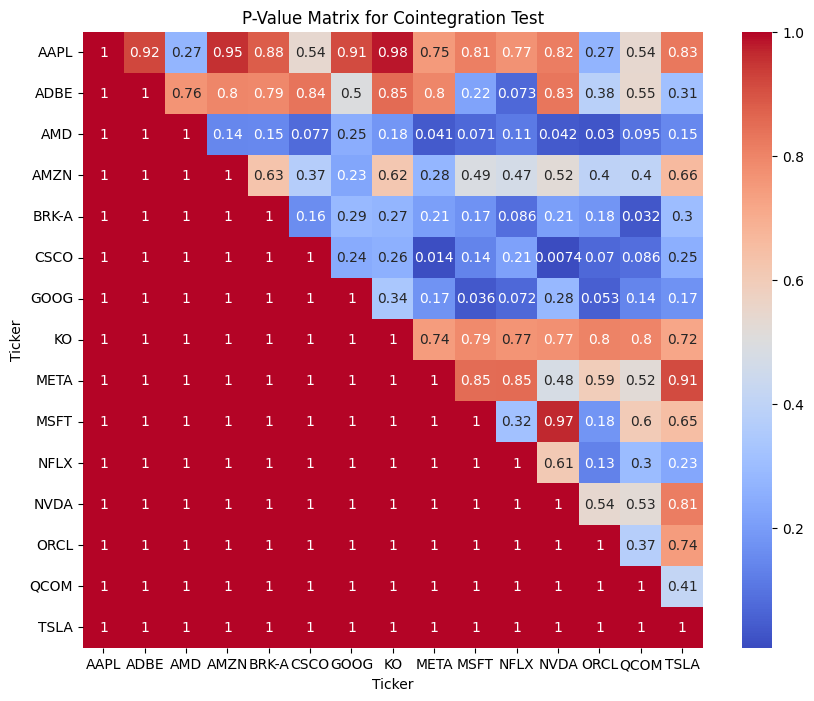

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, annot=True, cmap='coolwarm')
plt.title('P-Value Matrix for Cointegration Test')
plt.show()

It Seems AMD and ORCL are Highly Cointegrated for the period of last month

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


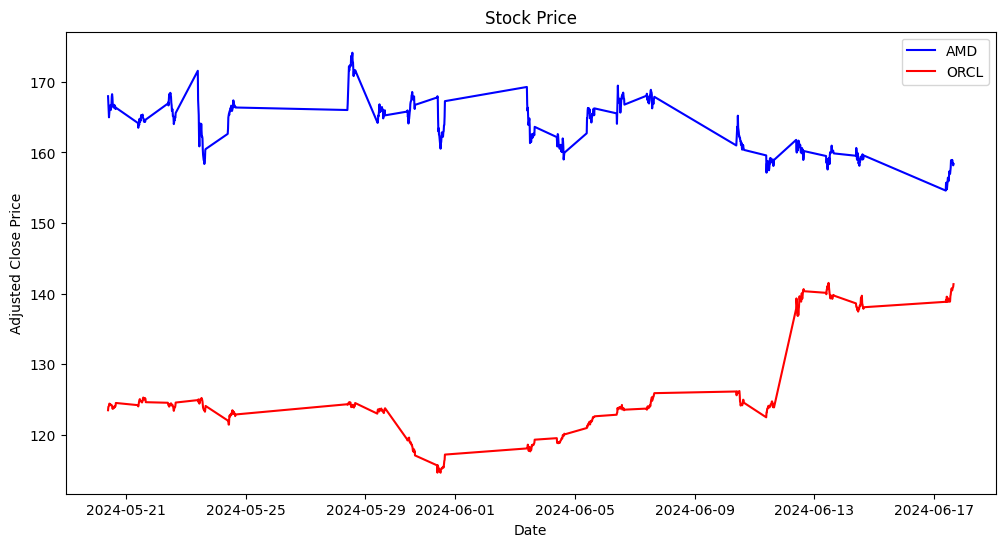

In [ ]:
ticker1 = "AMD"
ticker2 = "ORCL"
interval = '15m'  # 15-minute intervals
period = '1mo'   # Past month

# Function to download intraday data for the past month
def download_intraday_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    return data['Adj Close']

# Download data for both tickers
ts1 = download_intraday_data(ticker1, period, interval)
ts2 = download_intraday_data(ticker2, period, interval)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts1.index, ts1, label=ticker1, color='blue')
plt.plot(ts2.index, ts2, label=ticker2, color='red')
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [ ]:
ratios = df['AMD'] / df['ORCL']
print(len(ratios) * .70 )

359.79999999999995


In [ ]:
train = ratios[:397]
test = ratios[397:]
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0


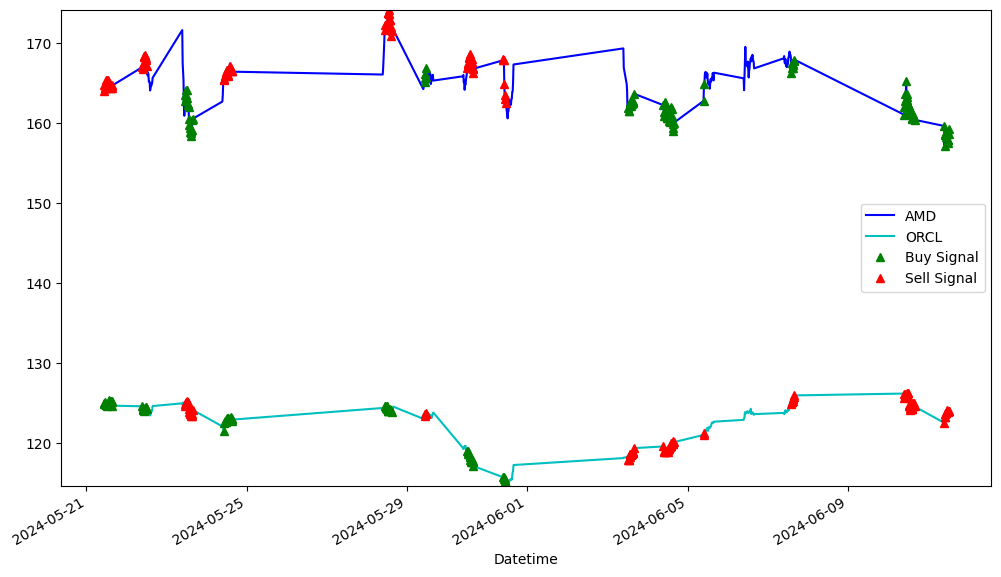

In [ ]:
plt.figure(figsize=(12,7))
S1 = df['AMD'].iloc[:397]
S2 = df['ORCL'].iloc[:397]

S1[30:].plot(color='b')
S2[30:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[30:].plot(color='g', linestyle='None', marker='^')
sellR[30:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
# plt.ylim(25, 105)
# plt.xlim('2013-03-22', '2020-07-05')

plt.legend(['AMD', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
trade(df['AMD'].iloc[397:], df['ORCL'].iloc[397:], 40, 2)

89.71952047867472

In [ ]:
df['spread'] = ts1 - ts2
df['zscore'] = (df['spread'] - df['spread'].rolling(window=40).mean()) / df['spread'].rolling(window=40).std()
df = df.dropna()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
features = ['spread', 'zscore']
df['signal'] = np.where(df['zscore'] > 2, -1, np.where(df['zscore'] < -2, 1, 0))
X = df[features]
y = df['signal']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
model = LogisticRegression(random_state=42)

# Lists to store performance metrics
accuracy_scores = []
cumulative_returns = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Generate returns based on predicted signals
    returns = pd.DataFrame(index=X_test.index)
    returns['returns'] = y_pred[:-1] * (ts1.pct_change().iloc[test_index[1:]] - ts2.pct_change().iloc[test_index[1:]])
    returns['cumulative'] = (1 + returns['returns']).cumprod()
    cumulative_returns.append(returns['cumulative'].iloc[-1])

print("Mean Accuracy:", np.mean(accuracy_scores))

Mean Accuracy: 0.9012658227848103
